In [176]:
import pandas as pd
import numpy as np
import json
# import psycopg2
# from sqlalchemy import create_engine
# import os
# from dotenv import load_dotenv
# load_dotenv()

# from script.database_pipeline import Pipeline
from script.helper import *

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

In [177]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setting up DB

**Decided to put database on hold**

In [178]:
# username = os.getenv('PSQL_USER')
# password = os.getenv('PASS')
# host = os.getenv('HOST')
# port = os.getenv('PORT')

# db_url = (f"postgresql+psycopg2://{username}:{password}@{host}:{port}/data_prof")

In [179]:
# engine = create_engine(db_url)

In [180]:
# Converted into a csv
df = pd.read_csv('ds_2019.csv')

In [181]:
# pipe = Pipeline(engine)
# pipe.add_table(df, 'og')

### EDA

In the other two notebooks, I've found that salary is one of the features that the three groups, `not looking`, `passively looking`, and `actively looking` on. This is an attempt at a thorough salary analysis based previous findings.

### Looking at overall US

Breaking down into 3 groups

In [182]:
us = df[df['Country'] == 'United States'].copy()

In [183]:
us_cleaned = us.copy()

In [184]:
looking = us['LookingForAnotherJob'].value_counts().index

In [185]:
looking_map = { v: i for i, v in enumerate(looking)}

In [186]:
us_cleaned.loc[:, 'LookingForAnotherJob'] = us['LookingForAnotherJob'].map(looking_map)

In [187]:
features = ['SalaryUSD', 'YearsWithThisDatabase', 'YearsWithThisTypeOfJob', 'OtherPeopleOnYourTeam', \
             'Education', 'HoursWorkedPerWeek', 'Gender', 'EmploymentStatus']
target = ['LookingForAnotherJob']

### Salary

In [188]:
us_cleaned.loc[:, 'SalaryUSD'] = us['SalaryUSD'].apply(str).replace(',|\s+', '', regex=True).astype(float)

In [189]:
us_cleaned = us_cleaned[us_cleaned['SalaryUSD'] > 100]

In [190]:
nl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 0]
pl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 1]
al_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 2]

In [191]:
nl_salary = nl_cleaned['SalaryUSD']
pl_salary = pl_cleaned['SalaryUSD']
al_salary = al_cleaned['SalaryUSD']

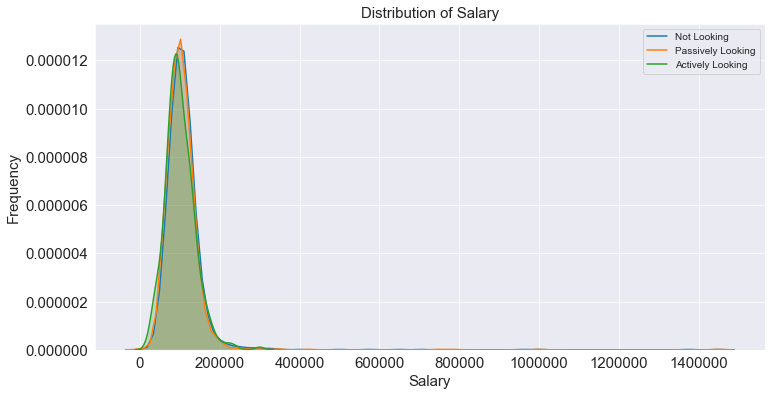

In [192]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_salary, pl_salary, al_salary, nl_label='Not Looking', pl_label='Passively Looking', al_label='Actively Looking', xlabel='Salary', ylabel='Frequency',
            title='Distribution of Salary'))

In [193]:
nl_salary_adj = outliers_removed(nl_salary)
pl_salary_adj = outliers_removed(pl_salary)
al_salary_adj = outliers_removed(al_salary)


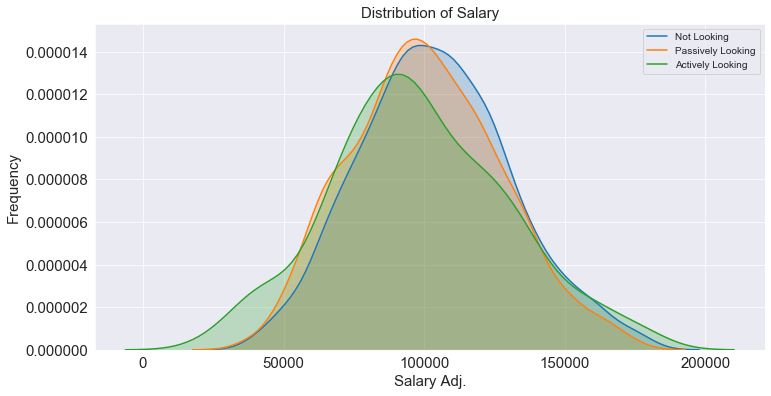

In [194]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_salary_adj, pl_salary_adj, al_salary_adj, nl_label='Not Looking', pl_label='Passively Looking', al_label='Actively Looking', xlabel='Salary Adj.', ylabel='Frequency',
            title='Distribution of Salary'))

## The analysis from this point on will mainly be looking at the salary without the outliers.

### PostalCodes

In [195]:
with open('postcodeclean.json', 'r') as f:
    results_combined = json.load(f)

In [196]:
def transform_zipcode(row):
    if row in results_combined:
        return results_combined[row]
    return row

In [197]:
us_cleaned.loc[:, 'States'] = us_cleaned['PostalCode'].apply(transform_zipcode)
nl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 0]
pl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 1]
al_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 2]

nl_salary_adj = outliers_removed(nl_salary)
pl_salary_adj = outliers_removed(pl_salary)
al_salary_adj = outliers_removed(al_salary)


In [198]:
us_cleaned = us_cleaned.drop('PostalCode', axis=1)

#### Salary of top 5 states

In [199]:
top5_states = us_cleaned['States'].value_counts().index[1:6]

In [200]:
state_salary = [(nl_salary_adj[nl_cleaned['States'] == state], pl_salary_adj[pl_cleaned['States'] == state], al_salary_adj[al_cleaned['States'] == state]) for state in top5_states]


#### California

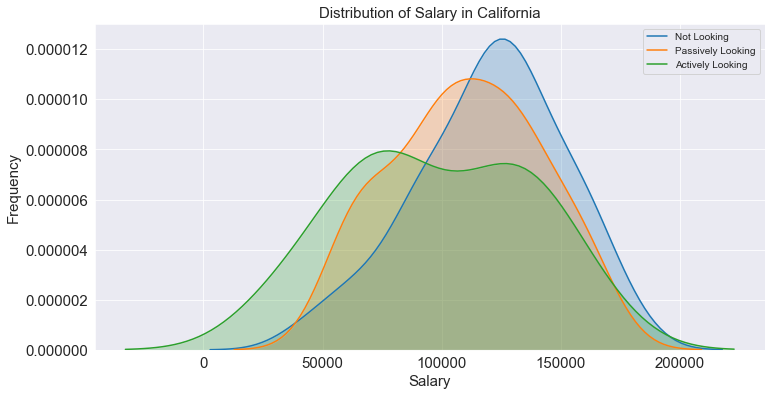

In [201]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, state_salary[0][0], state_salary[0][1], state_salary[0][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary in {top5_states[0]}')


#### Texas

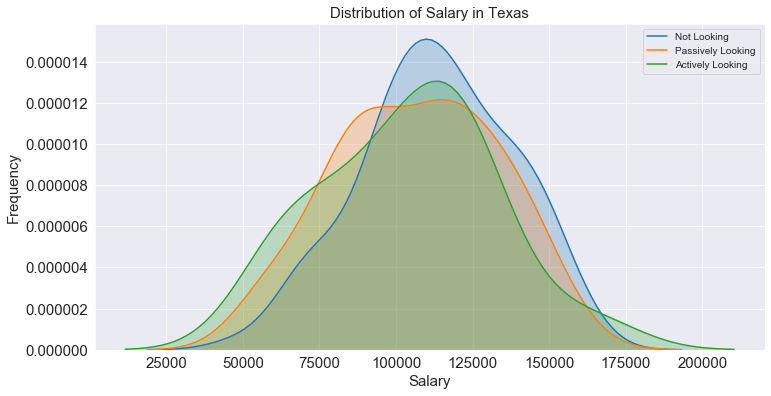

In [202]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, state_salary[1][0], state_salary[1][1], state_salary[1][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary in {top5_states[1]}')


#### Washington

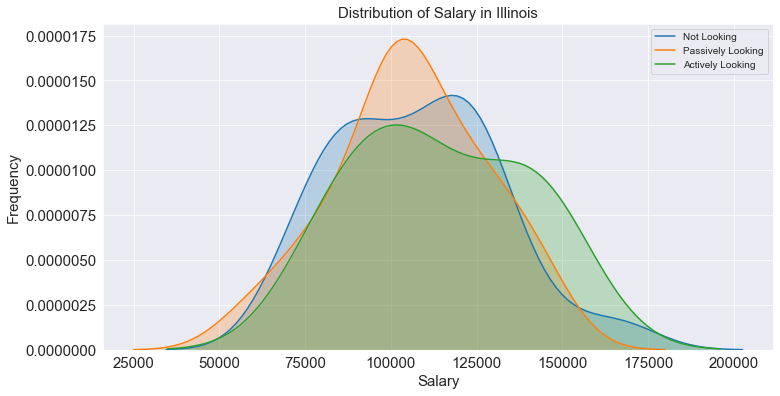

In [203]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, state_salary[2][0], state_salary[2][1], state_salary[2][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary in {top5_states[2]}')


#### Illinois

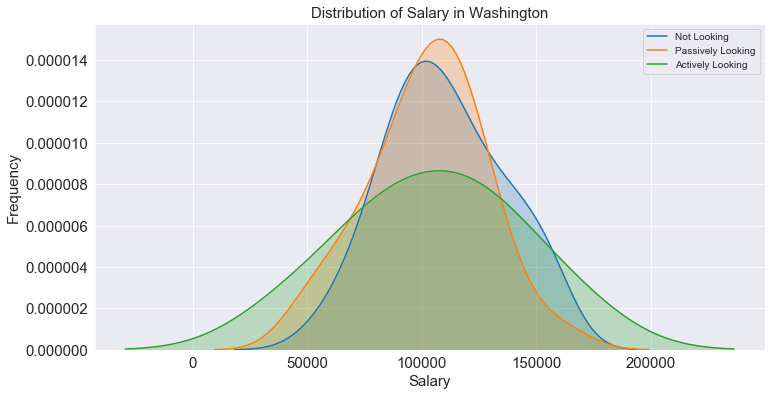

In [204]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, state_salary[3][0], state_salary[3][1], state_salary[3][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary in {top5_states[3]}')


#### Pennsylvania

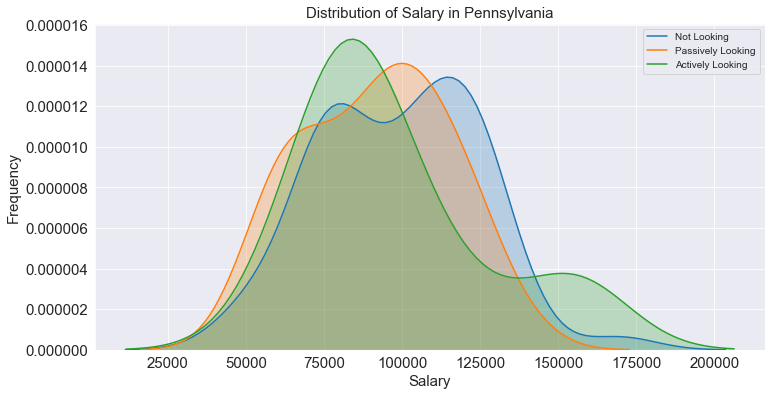

In [205]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, state_salary[4][0], state_salary[4][1], state_salary[4][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary in {top5_states[4]}')


### Employment Status

In [206]:
def transform_es(row):
    if ('Full' in row):
        return 'Full Time'
    elif ('Independent' in row):
        return 'Independent'
    else:
        return 'Part Time'

In [207]:
us_cleaned.loc[:, 'EmploymentStatus'] = us_cleaned.loc[:, 'EmploymentStatus'].apply(transform_es)
nl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 0]
pl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 1]
al_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 2]


In [208]:
nl_full = nl_salary_adj[nl_cleaned['EmploymentStatus'] == 'Full Time']
pl_full = pl_salary_adj[pl_cleaned['EmploymentStatus'] == 'Full Time']
al_full = al_salary_adj[al_cleaned['EmploymentStatus'] == 'Full Time']

nl_ind = nl_salary_adj[nl_cleaned['EmploymentStatus'] == 'Independent']
pl_ind = pl_salary_adj[pl_cleaned['EmploymentStatus'] == 'Independent']
al_ind = al_salary_adj[al_cleaned['EmploymentStatus'] == 'Independent']

nl_part = nl_salary_adj[nl_cleaned['EmploymentStatus'] == 'Part Time']
pl_part = pl_salary_adj[pl_cleaned['EmploymentStatus'] == 'Part Time']
al_part = al_salary_adj[al_cleaned['EmploymentStatus'] == 'Part Time']

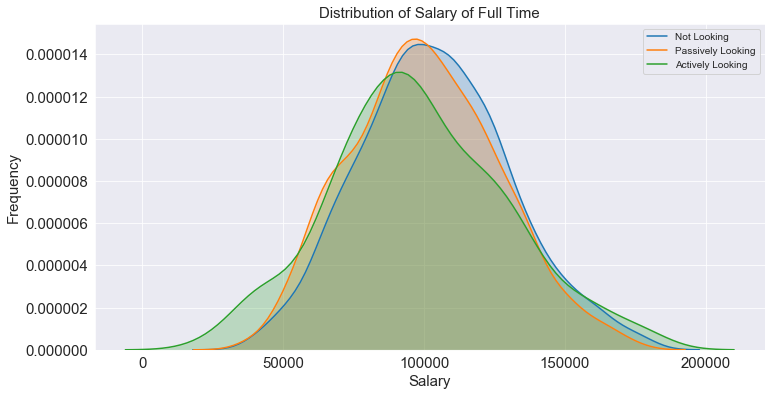

In [209]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_full, pl_full, al_full, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Full Time')


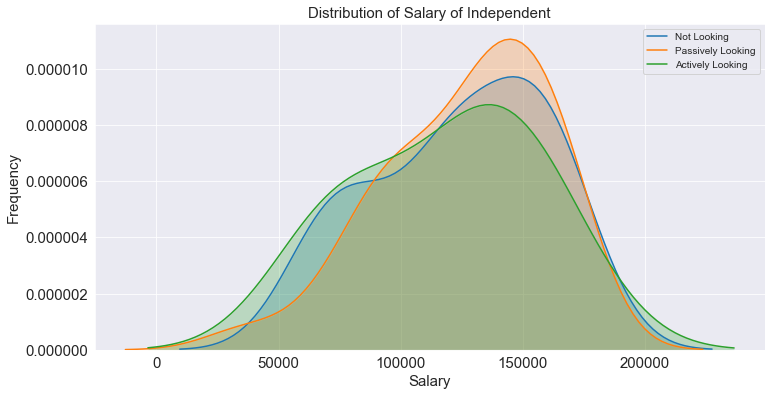

In [210]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_ind, pl_ind, al_ind, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Independent')


Not enough data to plot Part Time

/usr/local/anaconda3/envs/cap1/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/envs/cap1/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


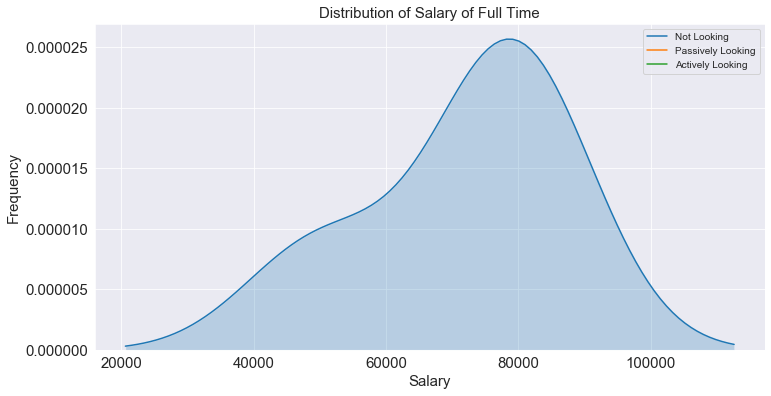

In [211]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_part, pl_part, al_part, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Full Time')


### Education

In [212]:
us_cleaned.loc[:, 'Education'] = us_cleaned['Education'].replace('\\(.*\\)', '', regex=True).str.strip()
nl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 0]
pl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 1]
al_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 2]


In [213]:
edu = ['None', 'Associates', 'Bachelors', 'Masters', 'Doctorate/PhD']

In [214]:
all_edu = [(nl_salary_adj[nl_cleaned['Education'] == e], pl_salary_adj[pl_cleaned['Education'] == e], al_salary_adj[al_cleaned['Education'] == e])for e in edu]



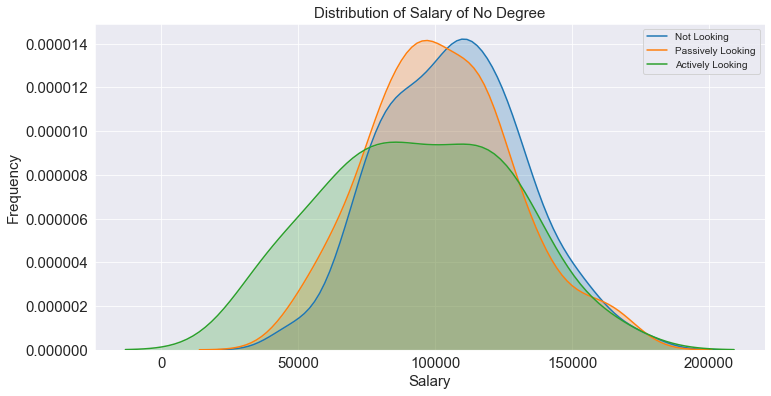

In [215]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, all_edu[0][0], all_edu[0][1], all_edu[0][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of No Degree')


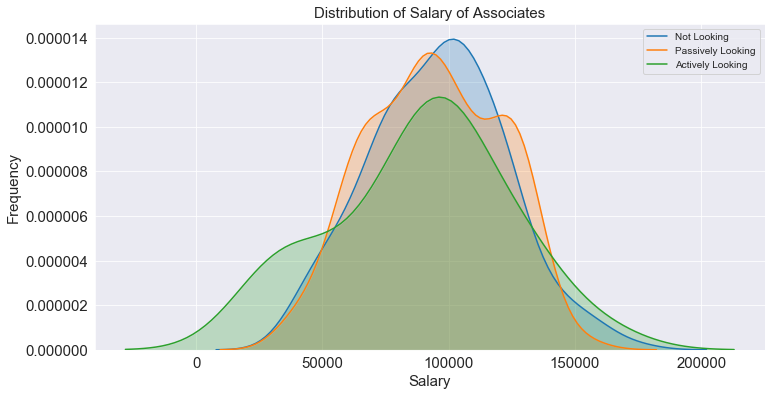

In [216]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, all_edu[1][0], all_edu[1][1], all_edu[1][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of {edu[1]}')


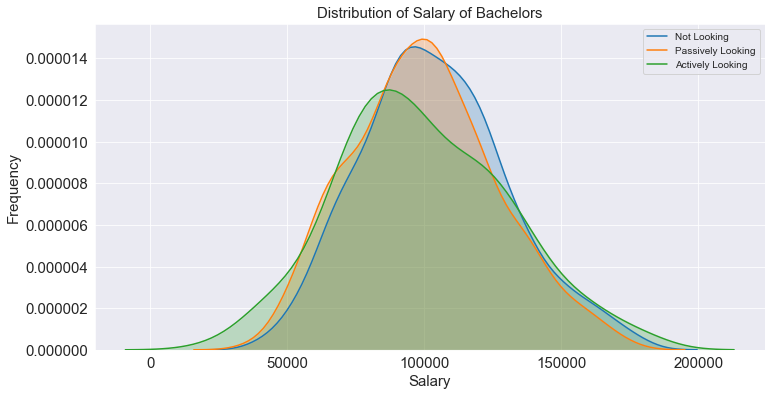

In [217]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, all_edu[2][0], all_edu[2][1], all_edu[2][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of {edu[2]}')


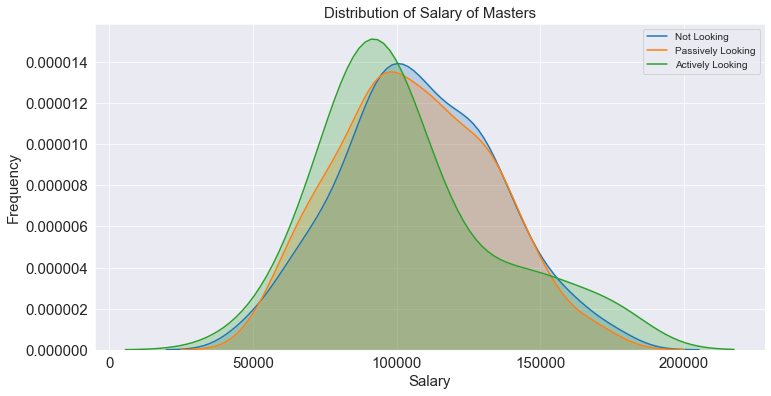

In [218]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, all_edu[3][0], all_edu[3][1], all_edu[3][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of {edu[3]}')


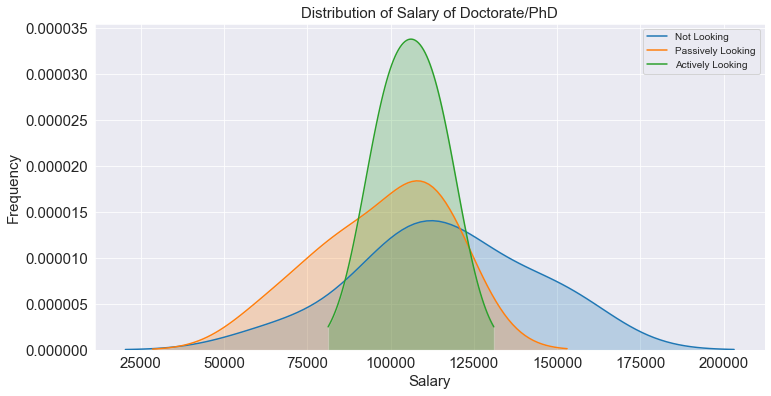

In [219]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, all_edu[4][0], all_edu[4][1], all_edu[4][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of {edu[4]}')


### Years With This Database

In [220]:
# Clean out values with greater than 100
us_cleaned.loc[:, 'YearsWithThisDatabase'] = us_cleaned.loc[us_cleaned['YearsWithThisDatabase'] < 100, 'YearsWithThisDatabase']
nl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 0]
pl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 1]
al_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 2]


In [221]:
mean_yrdb = us_cleaned['YearsWithThisDatabase'].mean()

In [222]:
nl_yrdb_g = nl_salary_adj[(nl_cleaned['YearsWithThisDatabase'] >= mean_yrdb)]
pl_yrdb_g = pl_salary_adj[(pl_cleaned['YearsWithThisDatabase'] >= mean_yrdb)]
al_yrdb_g = al_salary_adj[(al_cleaned['YearsWithThisDatabase'] >= mean_yrdb)]

nl_yrdb_l = nl_salary_adj[(nl_cleaned['YearsWithThisDatabase'] < mean_yrdb)]
pl_yrdb_l = pl_salary_adj[(pl_cleaned['YearsWithThisDatabase'] < mean_yrdb)]
al_yrdb_l = al_salary_adj[(al_cleaned['YearsWithThisDatabase'] < mean_yrdb)]


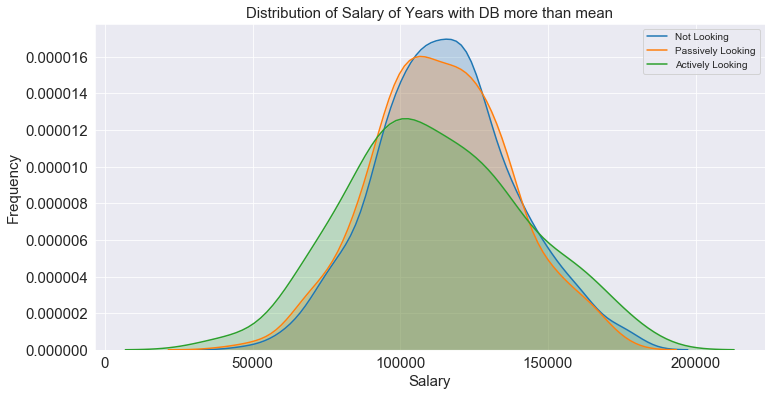

In [223]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_yrdb_g, pl_yrdb_g, al_yrdb_g, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Years with DB more than mean')


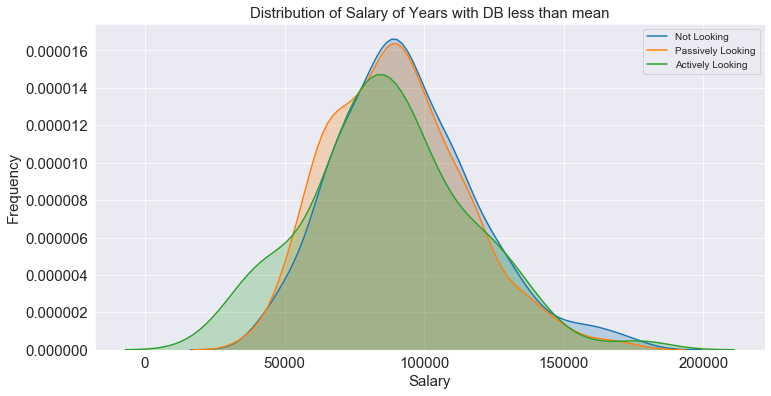

In [224]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_yrdb_l, pl_yrdb_l, al_yrdb_l, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Years with DB less than mean')


### YearsWithThisTypeOfJob

In [225]:
mean_yrjb = us_cleaned['YearsWithThisTypeOfJob'].mean()

In [226]:
nl_yrjb_g = nl_salary_adj[(nl_cleaned['YearsWithThisTypeOfJob'] >= mean_yrjb)]
pl_yrjb_g = pl_salary_adj[(pl_cleaned['YearsWithThisTypeOfJob'] >= mean_yrjb)]
al_yrjb_g = al_salary_adj[(al_cleaned['YearsWithThisTypeOfJob'] >= mean_yrjb)]

nl_yrjb_l = nl_salary_adj[(nl_cleaned['YearsWithThisTypeOfJob'] < mean_yrjb)]
pl_yrjb_l = pl_salary_adj[(pl_cleaned['YearsWithThisTypeOfJob'] < mean_yrjb)]
al_yrjb_l = al_salary_adj[(al_cleaned['YearsWithThisTypeOfJob'] < mean_yrjb)]


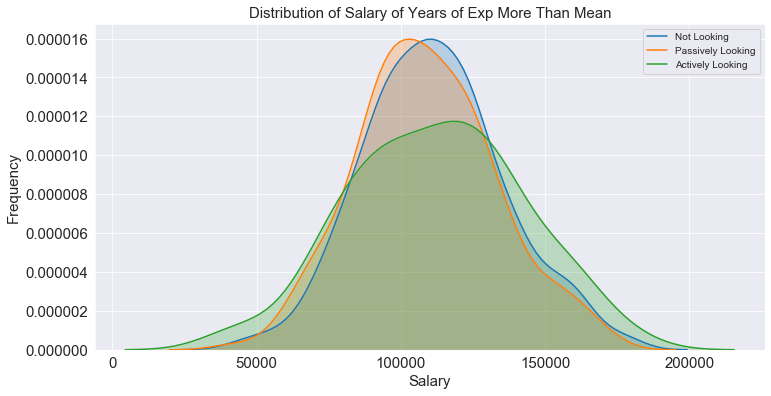

In [227]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_yrjb_g, pl_yrjb_g, al_yrjb_g, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Years of Exp More Than Mean')


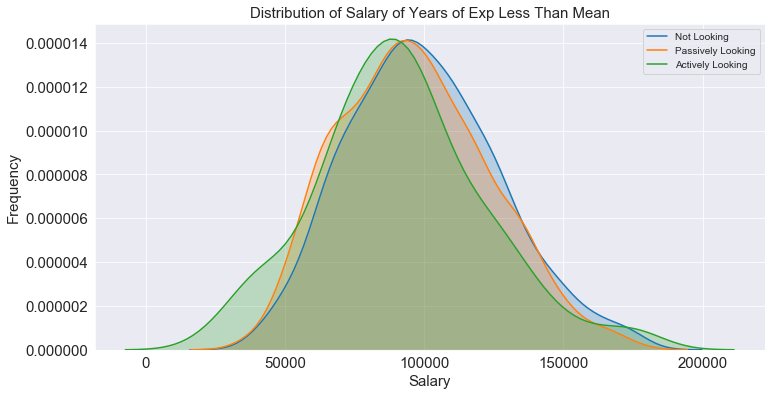

In [228]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_yrjb_l, pl_yrjb_l, al_yrjb_l, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Years of Exp Less Than Mean')


### OtherPeopleOnYourTeam

In [229]:
nl_mask0 = nl_cleaned['OtherPeopleOnYourTeam'] == 'None'
pl_mask0 = pl_cleaned['OtherPeopleOnYourTeam'] == 'None'
al_mask0 = al_cleaned['OtherPeopleOnYourTeam'] == 'None'

nl_mask1 = nl_cleaned['OtherPeopleOnYourTeam'] != 'None'
pl_mask1 = pl_cleaned['OtherPeopleOnYourTeam'] != 'None'
al_mask1 = al_cleaned['OtherPeopleOnYourTeam'] != 'None'


In [230]:
nl_nopoyt = nl_salary_adj[nl_mask0]
pl_nopoyt = pl_salary_adj[pl_mask0]
al_nopoyt = al_salary_adj[al_mask0]

nl_opoyt = nl_salary_adj[nl_mask1]
pl_opoyt = pl_salary_adj[pl_mask1]
al_opoyt = al_salary_adj[al_mask1]


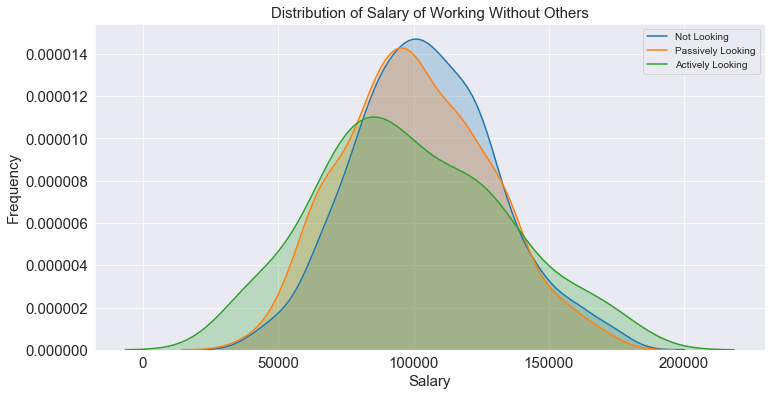

In [231]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_nopoyt, pl_nopoyt, al_nopoyt, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Working Without Others')


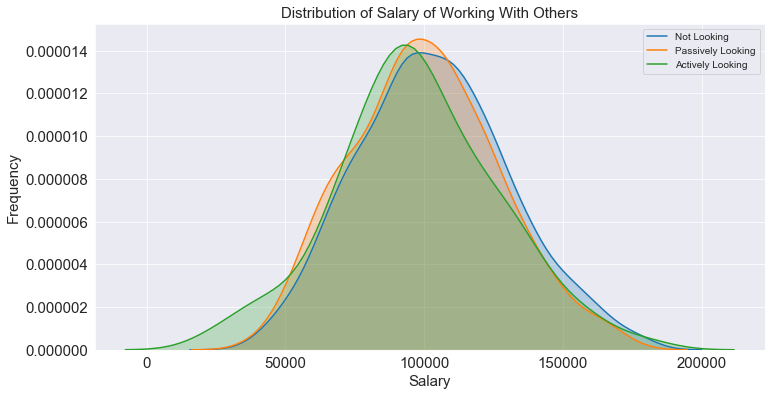

In [232]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_opoyt, pl_opoyt, al_opoyt, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Working With Others')


### HoursWorkedPerWeek

In [233]:
mean_hours = us_cleaned['HoursWorkedPerWeek'].mean()

In [234]:
nl_hours_g = nl_salary_adj[(nl_cleaned['HoursWorkedPerWeek'] >= mean_hours)]
pl_hours_g = pl_salary_adj[(pl_cleaned['HoursWorkedPerWeek'] >= mean_hours)]
al_hours_g = al_salary_adj[(al_cleaned['HoursWorkedPerWeek'] >= mean_hours)]

nl_hours_l = nl_salary_adj[(nl_cleaned['HoursWorkedPerWeek'] < mean_hours)]
pl_hours_l = pl_salary_adj[(pl_cleaned['HoursWorkedPerWeek'] < mean_hours)]
al_hours_l = al_salary_adj[(al_cleaned['HoursWorkedPerWeek'] < mean_hours)]

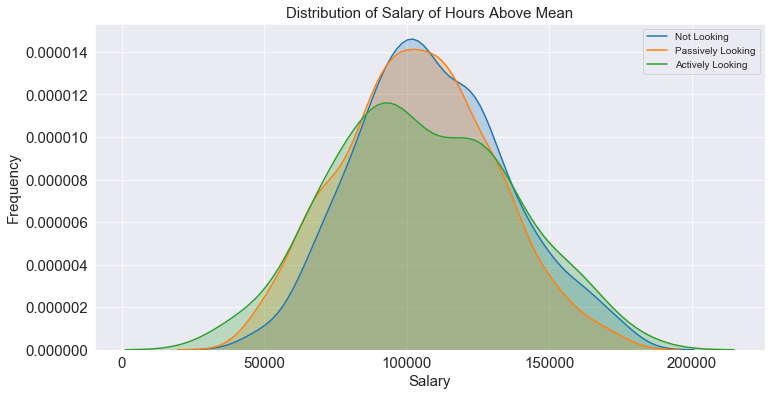

In [235]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_hours_g, pl_hours_g, al_hours_g, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Hours Above Mean')


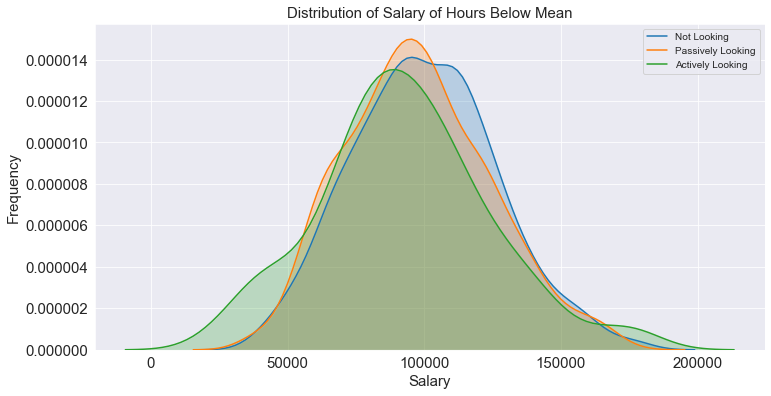

In [236]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_hours_l, pl_hours_l, al_hours_l, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Hours Below Mean')


### Gender

In [237]:
nl_mask_m = nl_cleaned['Gender'] == 'Male'
pl_mask_m = pl_cleaned['Gender'] == 'Male'
al_mask_m = al_cleaned['Gender'] == 'Male'

nl_mask_f = nl_cleaned['Gender'] == 'Female'
pl_mask_f = pl_cleaned['Gender'] == 'Female'
al_mask_f = al_cleaned['Gender'] == 'Female'

In [238]:
nl_gender_m = nl_salary_adj[nl_mask_m]
pl_gender_m = pl_salary_adj[pl_mask_m]
al_gender_m = al_salary_adj[al_mask_m]

nl_gender_f = nl_salary_adj[nl_mask_f]
pl_gender_f = pl_salary_adj[pl_mask_f]
al_gender_f = al_salary_adj[al_mask_f]

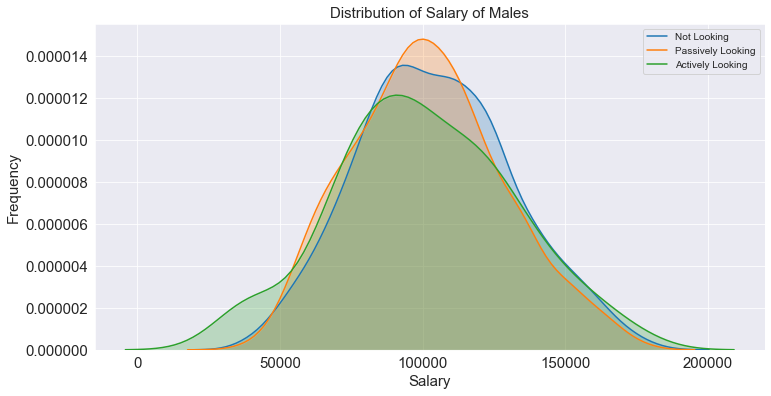

In [239]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_gender_m, pl_gender_m, al_gender_m, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Males')


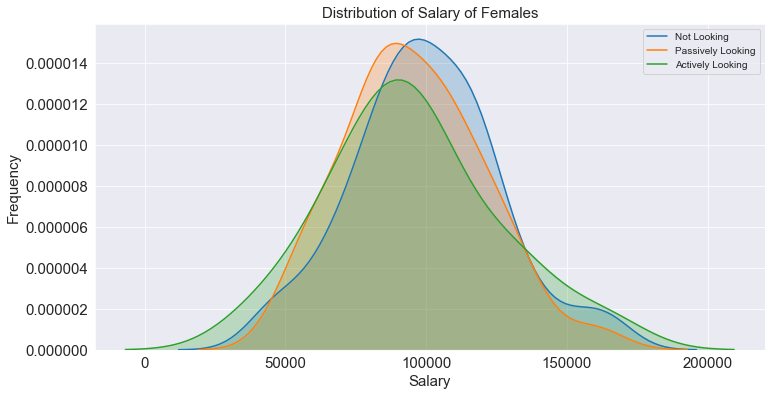

In [240]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_gender_f, pl_gender_f, al_gender_f, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Females')


### Primary Database

In [287]:
topdb = us_cleaned['PrimaryDatabase'].value_counts().index[0]

In [289]:
topdb

'Microsoft SQL Server'

In [288]:
nl_db = nl_salary_adj[(nl_cleaned['PrimaryDatabase'] == topdb)]
pl_db = pl_salary_adj[(pl_cleaned['PrimaryDatabase'] == topdb)]
al_db = al_salary_adj[(al_cleaned['PrimaryDatabase'] == topdb)]

nl_not_db = nl_salary_adj[(nl_cleaned['PrimaryDatabase'] != topdb)]
pl_not_db = pl_salary_adj[(pl_cleaned['PrimaryDatabase'] != topdb)]
al_not_db = al_salary_adj[(al_cleaned['PrimaryDatabase'] != topdb)]


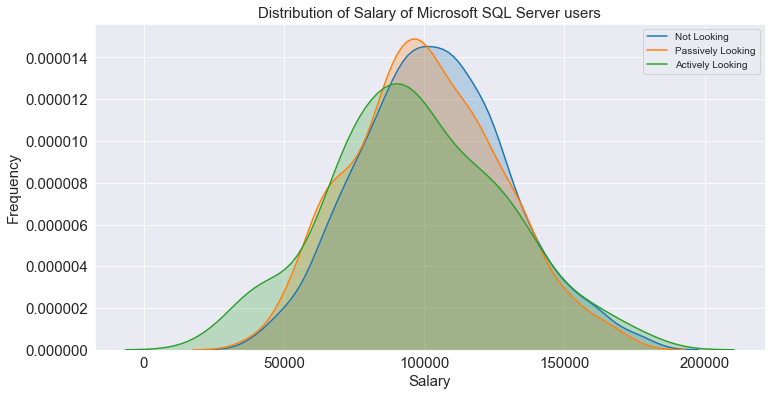

In [290]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_db, pl_db, al_db, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Microsoft SQL Server users')


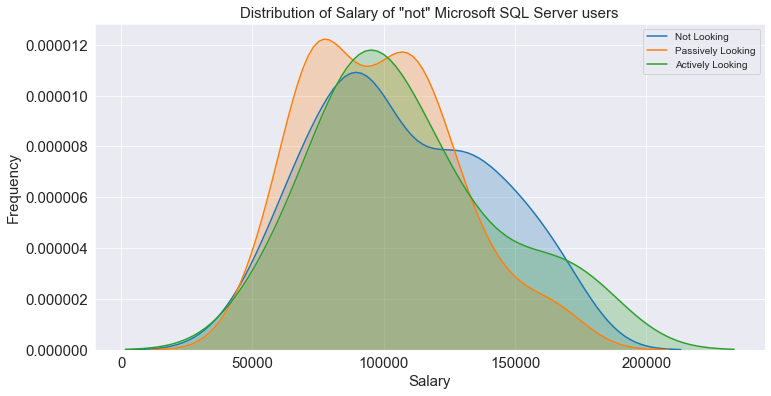

In [291]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_not_db, pl_not_db, al_not_db, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of "not" Microsoft SQL Server users')


## Hypothesis testing

**Caveat**

The three groups do not have the same sample size.  

More specifically

In [242]:
print('Not looking size:', nl_salary_adj.size)
print('Passively looking size:', pl_salary_adj.size)
print('Actively looking size:', al_salary_adj.size)

Not looking size: 2280
Passively looking size: 1799
Actively looking size: 301


### Testing, with a p value of 0.05

In [243]:
import scipy.stats as stats

In [361]:
def se_welch(n1, n2):
    s1 = n1.var()/(n1.size - 1)
    s2 = n2.var()/(n2.size - 1)
    
    return np.sqrt(s1 + s2)
    
    

In [416]:
def power_calc(n1, n2, alpha=.05):
    se = se_welch(n1, n2)

    null = stats.norm(0, se)
    alt = stats.norm(n1.mean() - n2.mean(), se)

    cv_left = null.ppf((alpha/2))
    cv_right = null.ppf(1 - (alpha/2))
    
    power = alt.cdf(cv_left) + 1 - alt.cdf(cv_right)
    
    return round(power, 2)

In [446]:
def power_analysis(n1, n2, n3):
    p1 = power_calc(n1, n2)
    p2 = power_calc(n2, n3)
    p3 = power_calc(n1, n3)
    
    print(f'Not & Passive: {p1:2.2f}')
    print(f'Passive & Active: {p2:2.2f}')
    print(f'Not & Active: {p3:2.2f}')

### Other People On Your Team

In [388]:
nl_nopoyt = nl_salary_adj[nl_mask0]
pl_nopoyt = pl_salary_adj[pl_mask0]
al_nopoyt = al_salary_adj[al_mask0]

nl_opoyt = nl_salary_adj[nl_mask1]
pl_opoyt = pl_salary_adj[pl_mask1]
al_opoyt = al_salary_adj[al_mask1]


In [392]:
samps_ttest(nl_nopoyt, pl_nopoyt, al_nopoyt)

(('nl, pl', 0.005216400256166427),
 ('pl, al', 0.5573731791391316),
 ('nl, al', 0.07660753560447747))

In [393]:
samps_ttest(nl_opoyt, pl_opoyt, al_opoyt)

(('nl, pl', 0.002255751279350332),
 ('pl, al', 0.24311643034352343),
 ('nl, al', 0.010164064471977305))

In [394]:
stats.ttest_ind(nl_nopoyt, nl_opoyt)

Ttest_indResult(statistic=0.9289129302664793, pvalue=0.35303262814763425)

In [395]:
stats.ttest_ind(pl_nopoyt, pl_opoyt)

Ttest_indResult(statistic=0.6076845549688366, pvalue=0.543473493041313)

In [396]:
stats.ttest_ind(al_nopoyt, al_opoyt)

Ttest_indResult(statistic=0.48124130679393695, pvalue=0.6306969940768792)

**Conclusion:**
Fail to reject null when comparing between working with others and not working with others.

Not Working With Others
- difference in salary between not looking and passively looking

Working with others
- difference in salary between not looking and passively looking
- difference in salary between not looking and actively looking

Across groups
- no difference between working alone and working with others

### Other People On Your Team Power Analysis

No Others

In [447]:
power_analysis(nl_nopoyt, pl_nopoyt, al_nopoyt)

Not & Passive: 0.80
Passive & Active: 0.09
Not & Active: 0.43


Others

In [448]:
power_analysis(nl_opoyt, pl_opoyt, al_opoyt)

Not & Passive: 0.87
Passive & Active: 0.21
Not & Active: 0.73


Not Looking

In [444]:
power = power_calc(nl_nopoyt, nl_opoyt)
print(f'Power of Test: {power:2.2f}')

Power of Test: 0.16


Passively Looking

In [445]:
power = power_calc(pl_nopoyt, pl_opoyt)
print(f'Power of Test: {power:2.2f}')

Power of Test: 0.09


Actively Looking

In [404]:
power = power_calc(al_nopoyt, al_opoyt)
print(f'Power of Test: {power:2.2f}')

Power of Test: 0.08


### Gender

In [250]:
nl_gender_m = nl_salary_adj[nl_mask_m]
pl_gender_m = pl_salary_adj[pl_mask_m]
al_gender_m = al_salary_adj[al_mask_m]

nl_gender_f = nl_salary_adj[nl_mask_f]
pl_gender_f = pl_salary_adj[pl_mask_f]
al_gender_f = al_salary_adj[al_mask_f]

In [251]:
samps_ttest(nl_gender_m, pl_gender_m, al_gender_m)

(('nl, pl', 0.01764232895050121),
 ('pl, al', 0.6401210905828465),
 ('nl, al', 0.12603392731683466))

In [252]:
samps_ttest(nl_gender_f, pl_gender_f, al_gender_f)

(('nl, pl', 0.1664155573208787),
 ('pl, al', 0.9449623354831271),
 ('nl, al', 0.40466990972692607))

In [319]:
stats.ttest_ind(nl_gender_m, nl_gender_f, equal_var=False)

Ttest_indResult(statistic=2.208845097558673, pvalue=0.028168191778525954)

In [320]:
stats.ttest_ind(pl_gender_m, pl_gender_f, equal_var=False)

Ttest_indResult(statistic=2.47326382507408, pvalue=0.01456867927004883)

In [321]:
stats.ttest_ind(al_gender_m, al_gender_f, equal_var=False)

Ttest_indResult(statistic=0.9161174438054313, pvalue=0.3641560242956161)

**Conclusions:**

Males
- difference in salary between not looking and passively looking

Females
- no difference between females

Across groups
- difference in salary between males and females
    - in both not looking and passively looking but not actively looking

**Caveat, females have significantly smaller sample size compare to males**

In [256]:
print('Male size:', nl_gender_m.size + pl_gender_m.size + al_gender_m.size)
print('Female size:', nl_gender_f.size + pl_gender_f.size + al_gender_f.size)

Male size: 2193
Female size: 316


### Gender power analysis

Males

In [449]:
power_analysis(nl_gender_m, pl_gender_m, al_gender_m)

Not & Passive: 0.66
Passive & Active: 0.08
Not & Active: 0.33


Females

In [450]:
power_analysis(nl_gender_f, pl_gender_f, al_gender_f)

Not & Passive: 0.29
Passive & Active: 0.05
Not & Active: 0.13


Not Looking

In [405]:
power = power_calc(nl_gender_m, nl_gender_f)
print(f'Power of Test: {power:2.2f}')

Power of Test: 0.60


Passively Looking

In [406]:
power = power_calc(pl_gender_m, pl_gender_f)
print(f'Power of Test: {power:2.2f}')

Power of Test: 0.69


Actively Looking

In [407]:
power = power_calc(al_gender_m, al_gender_f)
print(f'Power of Test: {power:2.2f}')

Power of Test: 0.15


### Years With This Type Of Job

In [257]:
mean_yrjb = us_cleaned['YearsWithThisTypeOfJob'].mean()

In [258]:
nl_yrjb_g = nl_salary_adj[(nl_cleaned['YearsWithThisTypeOfJob'] >= mean_yrjb)]
pl_yrjb_g = pl_salary_adj[(pl_cleaned['YearsWithThisTypeOfJob'] >= mean_yrjb)]
al_yrjb_g = al_salary_adj[(al_cleaned['YearsWithThisTypeOfJob'] >= mean_yrjb)]

nl_yrjb_l = nl_salary_adj[(nl_cleaned['YearsWithThisTypeOfJob'] < mean_yrjb)]
pl_yrjb_l = pl_salary_adj[(pl_cleaned['YearsWithThisTypeOfJob'] < mean_yrjb)]
al_yrjb_l = al_salary_adj[(al_cleaned['YearsWithThisTypeOfJob'] < mean_yrjb)]


In [259]:
samps_ttest(nl_yrjb_g, pl_yrjb_g, al_yrjb_g)

(('nl, pl', 0.04452786039123067),
 ('pl, al', 0.2559159481542416),
 ('nl, al', 0.7568310551154638))

In [260]:
samps_ttest(nl_yrjb_l, pl_yrjb_l, al_yrjb_l)

(('nl, pl', 0.001055807261821027),
 ('pl, al', 0.022371748930111617),
 ('nl, al', 0.0001403478275634083))

In [261]:
stats.ttest_ind(nl_yrjb_g, nl_yrjb_l)

Ttest_indResult(statistic=9.96129083145298, pvalue=6.572238062918175e-23)

In [262]:
stats.ttest_ind(pl_yrjb_g, pl_yrjb_l)

Ttest_indResult(statistic=9.461793931774704, pvalue=9.125698300921353e-21)

In [263]:
stats.ttest_ind(al_yrjb_g, al_yrjb_l)

Ttest_indResult(statistic=5.727251625632437, pvalue=2.485972909262118e-08)

**Conclusions:**

Above the mean
- difference between not looking and passively looking

Below the mean
- difference between not looking and actively looking

Across groups
- difference in mean salary in all three groups
    - there is a difference in salary between those who spend longer at the job than those who don't

### Years With This Type Of Job Power Analysis

In [451]:
power_analysis(nl_yrjb_g, pl_yrjb_g, al_yrjb_g)

Not & Passive: 0.52
Passive & Active: 0.21
Not & Active: 0.06


In [452]:
power_analysis(nl_yrjb_l, pl_yrjb_l, al_yrjb_l)

Not & Passive: 0.91
Passive & Active: 0.63
Not & Active: 0.97


Not Looking

In [417]:
power = power_calc(nl_yrjb_g, nl_yrjb_l)
print(f'Power of Test: {power:2.2f}')

Power of Test: 1.00


Passively Looking

In [418]:
power = power_calc(pl_yrjb_g, pl_yrjb_l)
print(f'Power of Test: {power:2.2f}')

Power of Test: 1.00


Actively Looking

In [419]:
power = power_calc(al_yrjb_g, al_yrjb_l)
print(f'Power of Test: {power:2.2f}')

Power of Test: 1.00


### Years With This Database

In [264]:
mean_yrdb = us_cleaned['YearsWithThisDatabase'].mean()

In [265]:
nl_yrdb_g = nl_salary_adj[(nl_cleaned['YearsWithThisDatabase'] >= mean_yrdb)]
pl_yrdb_g = pl_salary_adj[(pl_cleaned['YearsWithThisDatabase'] >= mean_yrdb)]
al_yrdb_g = al_salary_adj[(al_cleaned['YearsWithThisDatabase'] >= mean_yrdb)]

nl_yrdb_l = nl_salary_adj[(nl_cleaned['YearsWithThisDatabase'] < mean_yrdb)]
pl_yrdb_l = pl_salary_adj[(pl_cleaned['YearsWithThisDatabase'] < mean_yrdb)]
al_yrdb_l = al_salary_adj[(al_cleaned['YearsWithThisDatabase'] < mean_yrdb)]


In [266]:
samps_ttest(nl_yrdb_g, pl_yrdb_g, al_yrdb_g)

(('nl, pl', 0.1142058610426813),
 ('pl, al', 0.5754014827864871),
 ('nl, al', 0.22278368601240184))

In [267]:
samps_ttest(nl_yrdb_l, pl_yrdb_l, al_yrdb_l)

(('nl, pl', 0.002060527580186521),
 ('pl, al', 0.17363090480256668),
 ('nl, al', 0.0058720991538169995))

In [268]:
stats.ttest_ind(nl_yrdb_g, nl_yrdb_l)

Ttest_indResult(statistic=21.112698118537512, pvalue=1.662196385095972e-90)

In [269]:
stats.ttest_ind(pl_yrdb_g, pl_yrdb_l)

Ttest_indResult(statistic=20.454200783166762, pvalue=9.465380281385571e-84)

In [270]:
stats.ttest_ind(al_yrdb_g, al_yrdb_l)

Ttest_indResult(statistic=7.433666932627769, pvalue=1.1194588039477555e-12)

**Conclusions:**

Above the mean
- no difference in salary

Below the mean
- difference between not looking and passively looking
- difference between not looking and actively looking

Across groups
- difference in all three groups
    - there is a difference in salary between those who spend longer at with the database than those who don't

### Years With This Database Power Analysis

In [454]:
power_analysis(nl_yrdb_g, pl_yrdb_g, al_yrdb_g)

Not & Passive: 0.35
Passive & Active: 0.09
Not & Active: 0.23


In [455]:
power_analysis(nl_yrdb_l, pl_yrdb_l, al_yrdb_l)

Not & Passive: 0.87
Passive & Active: 0.28
Not & Active: 0.79


Not Looking

In [420]:
power = power_calc(nl_yrdb_g, nl_yrdb_l)
print(f'Power of Test: {power:2.2f}')

Power of Test: 1.00


Passively Looking

In [421]:
power = power_calc(pl_yrdb_g, pl_yrdb_l)
print(f'Power of Test: {power:2.2f}')

Power of Test: 1.00


Actively Looking

In [422]:
power = power_calc(al_yrdb_g, al_yrdb_l)
print(f'Power of Test: {power:2.2f}')

Power of Test: 1.00


### Primary Database

In [272]:
topdb = us_cleaned['PrimaryDatabase'].value_counts().index[0]

In [274]:
nl_db = nl_salary_adj[(nl_cleaned['PrimaryDatabase'] == topdb)]
pl_db = pl_salary_adj[(pl_cleaned['PrimaryDatabase'] == topdb)]
al_db = al_salary_adj[(al_cleaned['PrimaryDatabase'] == topdb)]

nl_not_db = nl_salary_adj[(nl_cleaned['PrimaryDatabase'] != topdb)]
pl_not_db = pl_salary_adj[(pl_cleaned['PrimaryDatabase'] != topdb)]
al_not_db = al_salary_adj[(al_cleaned['PrimaryDatabase'] != topdb)]


In [281]:
samps_ttest(nl_db, pl_db, al_db)

(('nl, pl', 0.00024730253962112315),
 ('pl, al', 0.09237070478347446),
 ('nl, al', 0.0010088749871953752))

In [282]:
samps_ttest(nl_not_db, pl_not_db, al_not_db)

(('nl, pl', 0.031477601360534235),
 ('pl, al', 0.19571477319372726),
 ('nl, al', 0.8686292765427361))

In [283]:
stats.ttest_ind(nl_db, nl_not_db)

Ttest_indResult(statistic=-1.307354896904746, pvalue=0.19122414418436792)

In [284]:
stats.ttest_ind(pl_db, pl_not_db)

Ttest_indResult(statistic=0.9277861757353556, pvalue=0.3536430917340545)

In [285]:
stats.ttest_ind(al_db, al_not_db)

Ttest_indResult(statistic=-1.6075620508344934, pvalue=0.10898655083237344)

In [286]:
topdb

'Microsoft SQL Server'

**Conclusions:**

Microsoft SQL Server
- difference in salary between not looking and those who are looking

Not Microsoft SQL Server
- difference in salary between not looking and passively looking

Across groups
- no difference in salary between groups whether they're using Microsoft SQL Server or not Microsoft SQL Server.

### Primary Database Power Analysis

In [456]:
power_analysis(nl_db, pl_db, al_db)

Not & Passive: 0.96
Passive & Active: 0.39
Not & Active: 0.91


In [457]:
power_analysis(nl_not_db, pl_not_db, al_not_db)

Not & Passive: 0.59
Passive & Active: 0.25
Not & Active: 0.05


Not Looking

In [423]:
power = power_calc(nl_db, nl_not_db)
print(f'Power of Test: {power:2.2f}')

Power of Test: 0.18


Passively Looking

In [424]:
power = power_calc(pl_db, pl_not_db)
print(f'Power of Test: {power:2.2f}')

Power of Test: 0.14


Actively Looking

In [425]:
power = power_calc(al_db, al_not_db)
print(f'Power of Test: {power:2.2f}')

Power of Test: 0.31


### Future plans

In [615]:
# countries_more_than_ten = countries.index[countries > 10]
# df = df[df['Country'].isin(countries_more_than_ten)]
# df.head()

### Predictive pipelines